<a href="https://www.kaggle.com/code/naychilynn/age-and-gender-classification-multi-output?scriptVersionId=162260383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

*I hope this notebook is somewhat useful for someone who is looking for example of simultaneous regression and classification, and multi-resoulution CNN.
I am attempting to create a mutlti-output CNN model that predicts the age and gender of an individual simultaneously. 
I applied Tensorflow with Functional API that is capable to create models rather than sequential model. 
In this multi-output model, I implement the network architecture of Multiresolution CNN inspired by the achievement in video classification in this CVPR paper "[1] Large-Scale Video Classification with Convolutional Neural Networks".
Besides, I inspired other UTK Face notebooks by SACHIN MEENA, SUNEEL KUMAR PATEL and ERIN WARD.*
 



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model, to_categorical, load_img
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Cropping2D, Resizing, concatenate

2024-02-09 05:34:45.170182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 05:34:45.170291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 05:34:45.361102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [3]:
# labels - age, gender
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

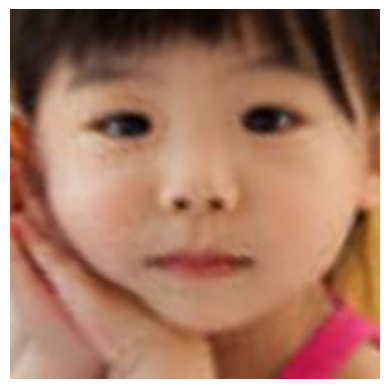

In [6]:
from PIL import Image
img = Image.open(df['image'][100])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

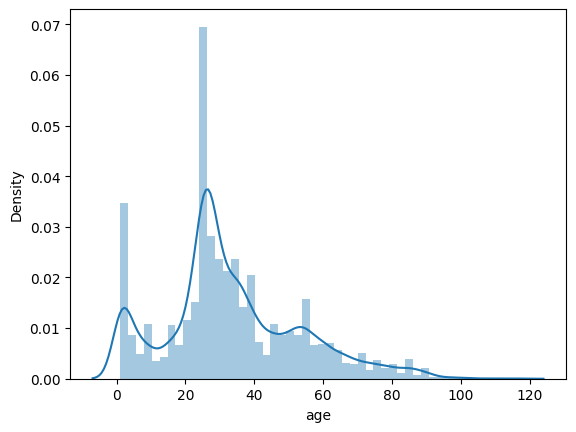

In [7]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

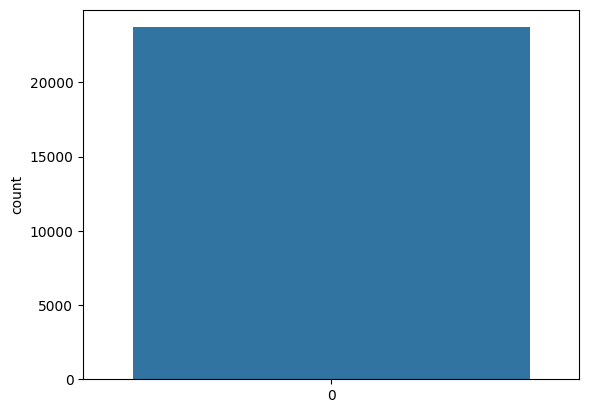

In [8]:
sns.countplot(df['gender'])

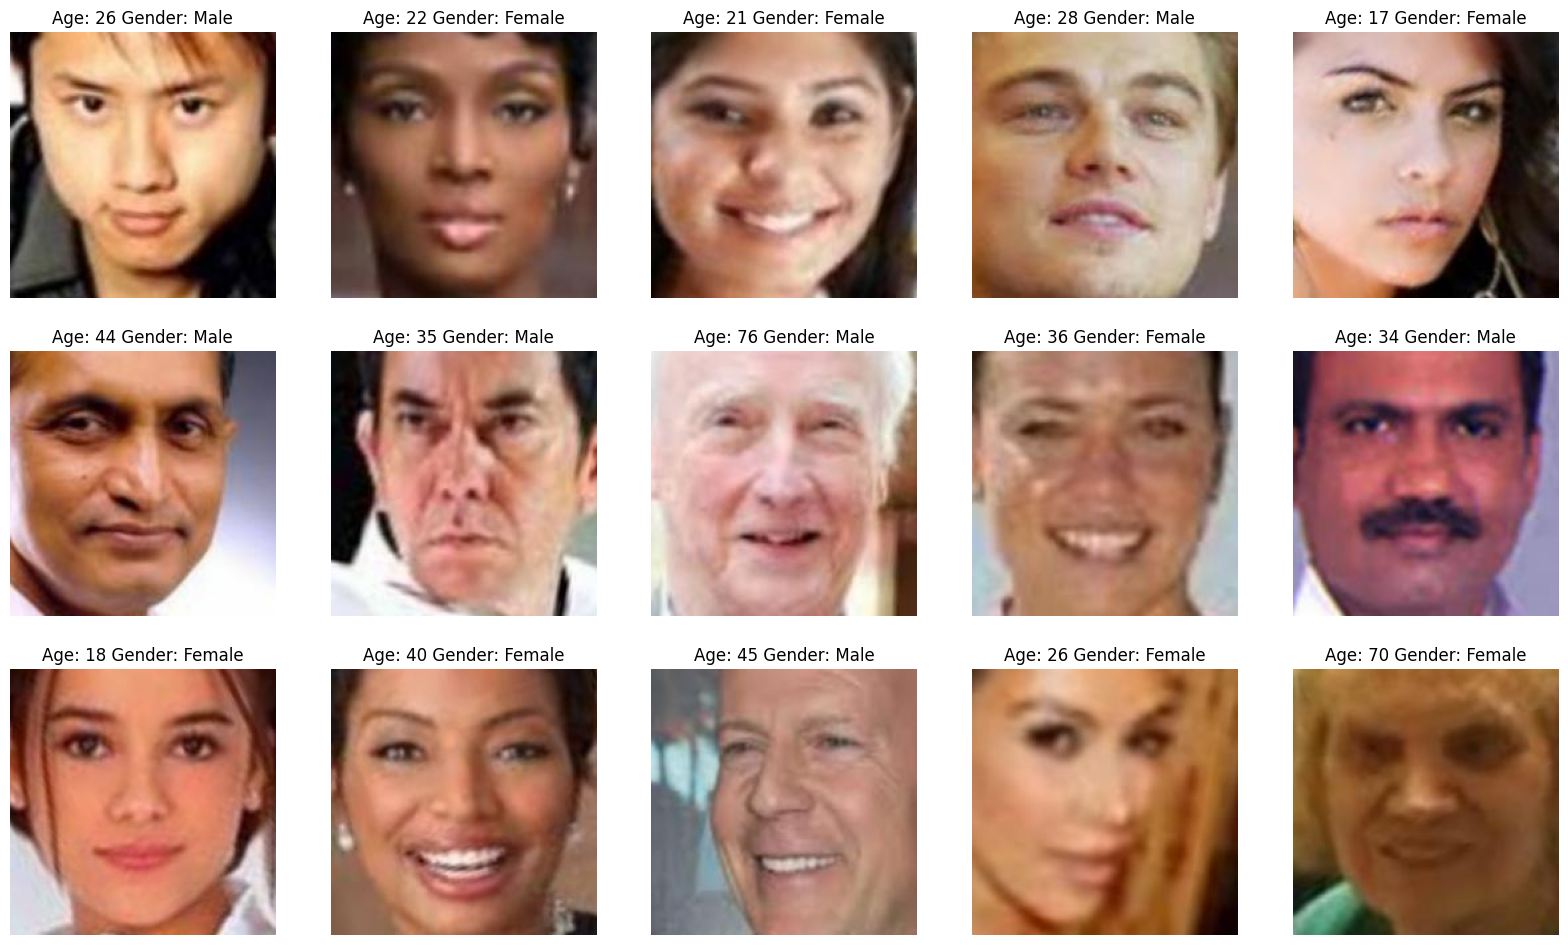

In [9]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:15]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [10]:
IMG_SIZE, CHANNEL = 128, 1
VAL_SPLIT = 0.2
LR_RATE = 2e-4
INITIAL_LEARN_RATE = 0.1
DECAY_STEP, DECAY_RATE = 1e5, 0.96
OPTIM = 0.0001
BATCH_SIZE, EPOCH = 16, 20


In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), IMG_SIZE, IMG_SIZE, CHANNEL)
    return features
X = extract_features(df['image'])
X.shape

  0%|          | 0/23708 [00:00<?, ?it/s]

(23708, 128, 128, 1)

In [12]:
# normalize the images
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (IMG_SIZE, IMG_SIZE, CHANNEL)
inputs = Input((input_shape))

*The architecture that I design here is based on CVPR paper [1]. The model uses two separate streams – ‘fovea’ and ‘context’ for learning features from different scaled-down resolutions, and concatenated later. This kind of architecture assists in shrinking the loss of important information.*

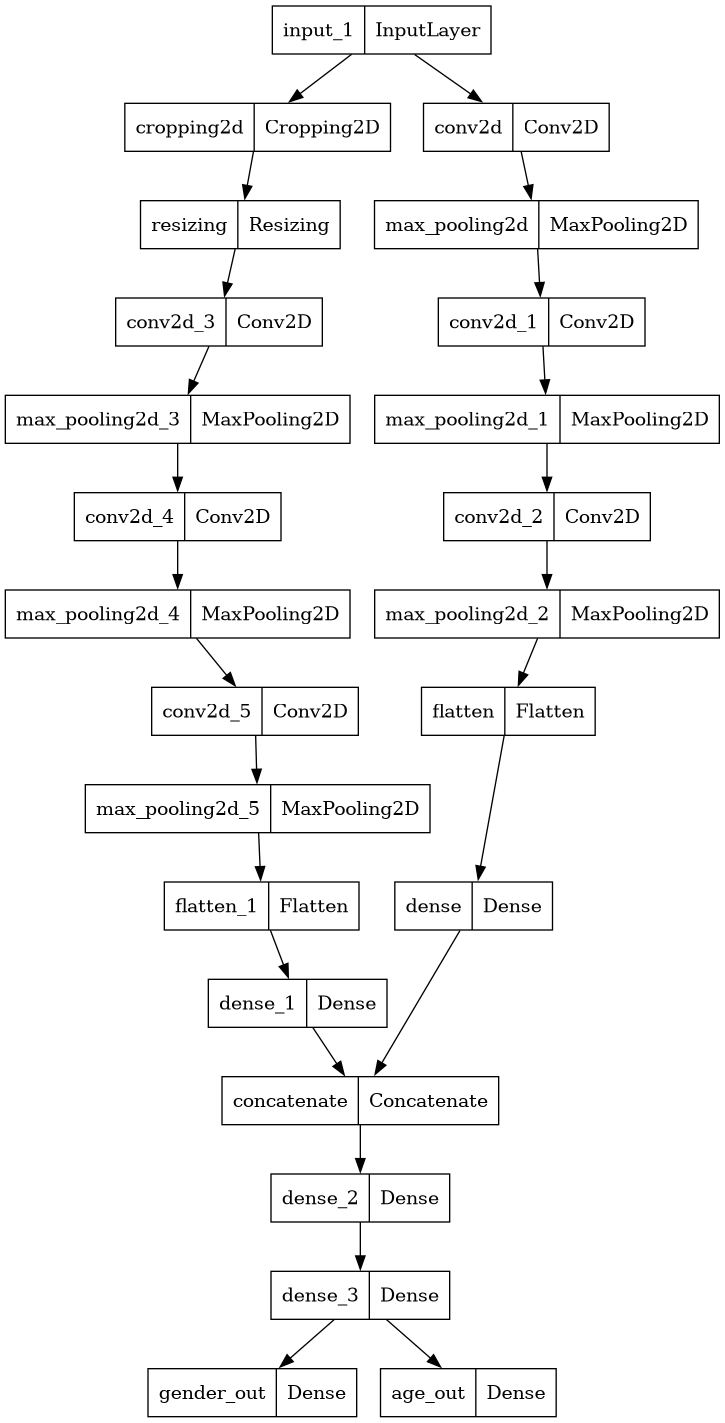

In [13]:
# Context Stream
context_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
context_pool1 = MaxPooling2D((2, 2))(context_conv1)

context_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(context_pool1)
context_pool2 = MaxPooling2D((2, 2))(context_conv2)

context_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(context_pool2)
context_pool3 = MaxPooling2D((2, 2))(context_conv3)

context_flatten = Flatten()(context_pool3)
context_dense1 = Dense(256, activation='relu')(context_flatten)

# FOVA1 Stream with Cropping and Resizing
fova_cropped = Cropping2D(cropping=((40, 40), (40, 40)))(inputs)  # Example cropping, adjust as needed
fova_resized = Resizing(IMG_SIZE, IMG_SIZE)(fova_cropped)

fova_conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(fova_resized)
fova_pool1 = MaxPooling2D((2, 2))(fova_conv1)

fova_conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(fova_pool1)
fova_pool2 = MaxPooling2D((2, 2))(fova_conv2)

fova_conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(fova_pool2)
fova_pool3 = MaxPooling2D((2, 2))(fova_conv3)

fova_flatten = Flatten()(fova_pool3)
fova_dense1 = Dense(256, activation='relu')(fova_flatten)


# Concatenate features from different streams
merged = concatenate([context_dense1, fova_dense1])
# # Concatenate features from different streams
# merged = concatenate([context_dense1, fova_dense1])

# Fully connected layers for joint processing
x = Dense(512, activation='relu')(merged)
x = Dense(256, activation='relu')(x)

# output
output_1 = Dense(1, activation='sigmoid', name='gender_out') (x)
output_2 = Dense(1, activation='relu', name='age_out') (x)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

plot_model(model)

In [14]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)


Epoch 1/20
1186/1186 [==============================] - 793s 667ms/step - loss: 19.0403 - gender_out_loss: 0.4872 - age_out_loss: 18.5530 - gender_out_accuracy: 0.7709 - age_out_accuracy: 0.0196 - val_loss: 8.8705 - val_gender_out_loss: 0.3830 - val_age_out_loss: 8.4874 - val_gender_out_accuracy: 0.8245 - val_age_out_accuracy: 0.0259
Epoch 2/20
1186/1186 [==============================] - 806s 680ms/step - loss: 8.4395 - gender_out_loss: 0.3537 - age_out_loss: 8.0858 - gender_out_accuracy: 0.8365 - age_out_accuracy: 0.0347 - val_loss: 7.8906 - val_gender_out_loss: 0.3418 - val_age_out_loss: 7.5488 - val_gender_out_accuracy: 0.8439 - val_age_out_accuracy: 0.0230
Epoch 3/20
1186/1186 [==============================] - 746s 629ms/step - loss: 7.3835 - gender_out_loss: 0.3101 - age_out_loss: 7.0733 - gender_out_accuracy: 0.8591 - age_out_accuracy: 0.0359 - val_loss: 7.2727 - val_gender_out_loss: 0.3036 - val_age_out_loss: 6.9691 - val_gender_out_accuracy: 0.8583 - val_age_out_accuracy: 0.0

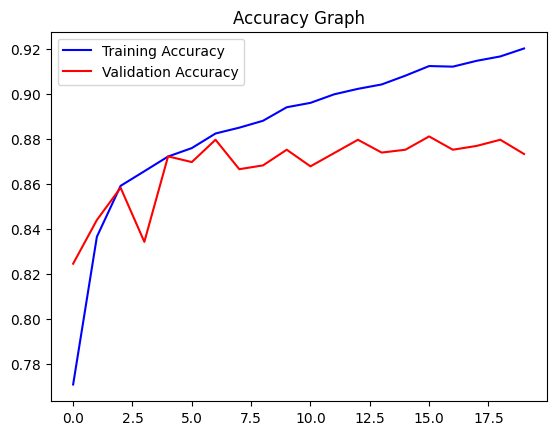

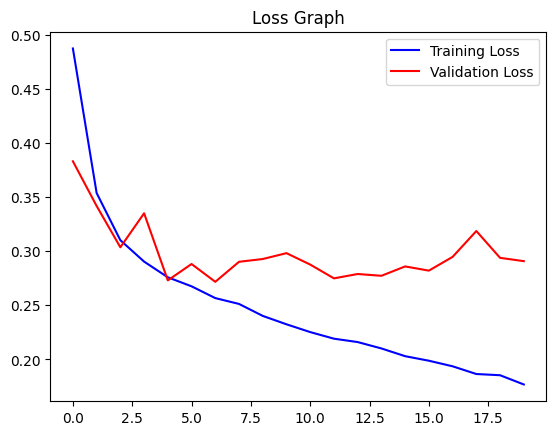

In [15]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

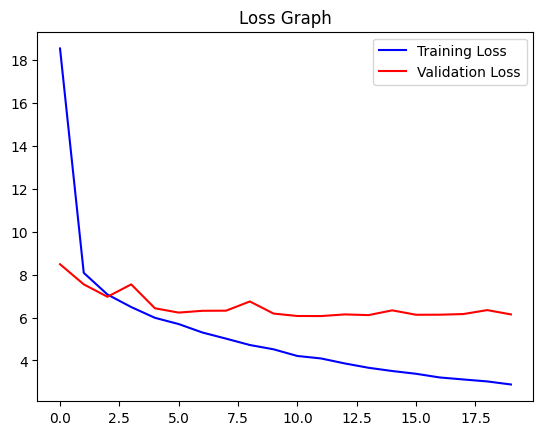

In [16]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female | Original Age: 3
1/1 [==============================] - 0s 279ms/step
Predicted Gender: Female | Predicted Age: 2


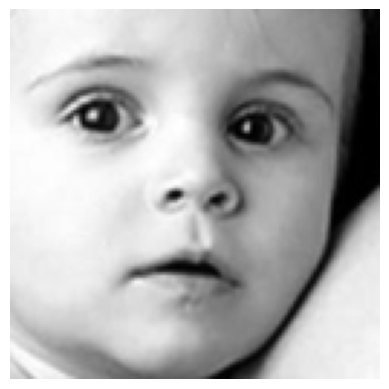

In [17]:
image_index = 900
print("Original Gender:", gender_dict[y_gender[image_index]], "| Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, IMG_SIZE, IMG_SIZE, CHANNEL))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "| Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');

**Thank you for visiting my notebook. I hope you would enjoy. Happy Coding! **
> **Nay Chi Lynn**